
# Intro


**Notes**

The main bulk of the material comes from https://developers.google.com/machine-learning/recommendation/overview/candidate-generation. If you want to go further later, you can take a look at http://nicolas-hug.com/blog/matrix_facto_3. It is absolutely not expected to look at these two links for the interviews  or to complete the test.

**Context**: 

We want to build a movies' recommender in order to get new movies to watch during the lock down. We will base our work on a variation of the MovieLens dataset. 
The data consists of movies seen by the users, some informations about the movies, and some informations about the users. The problem consists in predicting which movies a given user might like.

We are presenting you here first a naive approach in order to familarize yourself with the problem and show you how it might be solved.

**Task**:

The code presented is a first implementation but has a number of shortcomings in its structure and features (more on that in the conclusion). Your task consist in producing a refactoring, so as to be one step closer to a "clean" code.

**Evaluation**:

Our goal here is two fold:
- See how you understand a problem and adapt to an already given approach to tackle it.
- See how you can design new features.
- See how you manipulate python code: understanding, ideas to refactor etc ...

The projects will be evaluated on the quality of the source code produced.

## ----------- WE START OUR CODE HERE ----------------------------------------

## Step 0 - Business Understanding

The given subject consists on a movie recommandation engine. We have a set of ratings given by users to a specific movie, and the goal is to recommend accurate movie to a specific user. A content based approach has been proposed and our task is to see how we can improve it in a clearer code manner.

No evaluation metric has been suggested. The datasets are mainly csv files.

Time limited to 4 hours


**We propose ourself to tackle the problem of recommandation by following a simplified version of the CRISP-DM approach and explain each step of our process to ease the comprehension for other Data scientist and MLE, and to easily explain our choices to the businesss. We also include in it the task of providing a clean strutured code**

# Step 1 - Data Understanding

## 1.1 Data collection

First, let's load our datasets from the given sources. Our sources consist on 3 csv files, representing users, movies and the ratings given by users on some movies

In [381]:
#!pipenv install matplotlib
import pandas as pd

"""
Load all datasets from csv files
* input : A list of dataset paths
* return a list of dataframes
"""

def load_all_datasets(path_to_all_datasets):
    
    all_dataframes = []
    
    try:
        for path in path_to_all_datasets:
            all_dataframes.append(pd.read_csv(path))
        return all_dataframes
    except:
        return None

In [382]:
users,movies,ratings = load_all_datasets(["data/users.csv","data/movies.csv","data/ratings.csv"])

In [383]:
print(users.shape)
users.head()

(6040, 5)


,user_id,gender,age,occupation,zip_code
0,0,F,1,10,48067
1,1,M,56,16,70072
2,2,M,25,15,55117
3,3,M,45,7,02460
4,4,M,25,20,55455


In [384]:
print(movies.shape)
movies.head()

(3883, 21)


,movie_id,title,year,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,0,Toy Story,1995,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Jumanji,1995,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Grumpier Old Men,1995,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Waiting to Exhale,1995,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Father of the Bride Part II,1995,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [385]:
print(ratings.shape)
ratings.head()

(1000209, 3)


,user_id,movie_id,rating
0,0,1176,5
1,0,655,3
2,0,902,3
3,0,3339,4
4,0,2286,5


## 1.2 Data description and visualization

**Before performing any analysis, we have to take a look on our dataset, check the first descriptive statistics. This can enable us to make some useful hypothesis that we will use to design a better solution**

### User dataset

In [386]:
users.dtypes

user_id        int64
gender        object
age            int64
occupation     int64
zip_code      object
dtype: object

**There is a problem with the occupation type. It is supposed to be an object and not an integer. So we will transform it next, not to false our next analysis**

In [387]:
users = users.astype({"occupation":"object"})

In [388]:
users.describe()

,user_id,age
count,6040.000000,6040.000000
mean,3019.500000,30.639238
std,1743.742145,12.895962
min,0.000000,1.000000
25%,1509.750000,25.000000
50%,3019.500000,25.000000
75%,4529.250000,35.000000
max,6039.000000,56.000000


In [389]:
users.isnull().sum()

user_id       0
gender        0
age           0
occupation    0
zip_code      0
dtype: int64

The user table consist on 6040 entries. Each user is identified by 5 attributes:
* user_id : A unique id to locate each user in the dataset
* gender : An attribute representing the gender of the user. This is categorical variable
* occupation : It looks like representing the occupation category of the user. But we can see that it has been interpreted as an integer type, thus we will need to correct it
* Age : The age of the user. An integer ranging from 1 to 56.
* zipcode : the code representing the location of the user

**Main highlights**
* We have a minimum value of age set at 1, but we all know that a child cannot rate a movie, thus this might be an outlier. To be seen when plotting data distribution
* There are no null values. This is a good news

**Let's visualize the user dataset**

In [390]:
import matplotlib.pyplot as plt

def visualize_user_dataset(user_dataset):
        fig, axes = plt.subplots(1,2)
        axes[0].boxplot(user_dataset["age"])
        axes[0].set_title("Age boxplot distribution")
        
        axes[1].hist(user_dataset["occupation"])
        axes[1].set_title("Occupation distribution")
        
        plt.tight_layout()
        

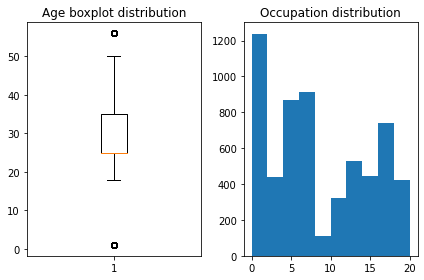

In [391]:
visualize_user_dataset(users)

**Main highlights**
* As said previously there is an outlier concerning the user with 1 year old. But there is also an outlier above the age of 50
* Most users in our dataset have occupation category number 0,1, 4, 5, 17

### Movies dataset

In [392]:
movies.dtypes

movie_id         int64
title           object
year             int64
Animation      float64
Children's     float64
Comedy         float64
Adventure      float64
Fantasy        float64
Romance        float64
Drama          float64
Action         float64
Crime          float64
Thriller       float64
Horror         float64
Sci-Fi         float64
Documentary    float64
War            float64
Musical        float64
Mystery        float64
Film-Noir      float64
Western        float64
dtype: object

In [393]:
movies.describe()

,movie_id,year,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
count,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000
mean,1941.000000,1986.066959,0.027041,0.064641,0.309039,0.072882,0.017512,0.121298,0.412825,0.129539,0.054339,0.126706,0.088334,0.071079,0.032707,0.036827,0.029359,0.027298,0.011331,0.017512
std,1121.069876,16.895690,0.162224,0.245923,0.462157,0.259976,0.131187,0.326515,0.492405,0.335839,0.226715,0.332686,0.283816,0.256990,0.177891,0.188362,0.168832,0.162973,0.105858,0.131187
min,0.000000,1919.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,970.500000,1982.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1941.000000,1994.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2911.500000,1997.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3882.000000,2000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [394]:
movies.isnull().sum()

movie_id       0
title          0
year           0
Animation      0
Children's     0
Comedy         0
Adventure      0
Fantasy        0
Romance        0
Drama          0
Action         0
Crime          0
Thriller       0
Horror         0
Sci-Fi         0
Documentary    0
War            0
Musical        0
Mystery        0
Film-Noir      0
Western        0
dtype: int64

The movies dataset consist on 3883 entries describe by 21 attributes.
* movie_id : It represents a unique id identifying a specific movie
* title : It represents the title of the movie
* year : The year when the movie was released
* 18 Other attributes representing the genre to which the movie can be assimilated. They consist on binary values. 0 if the movie does not belong to that genre or 1 otherwise

In [395]:
def visualize_movie_dataset(movie_dataset, not_genre_columns):
    
    movie_dataset.sum()[list(set(movie_dataset.columns.to_list())-set(not_genre_columns))].plot(kind="bar")
    

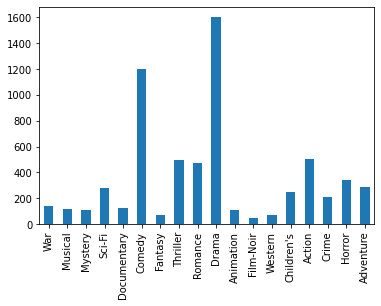

In [396]:
visualize_movie_dataset(movies, ["title","year","movie_id"])

**Most films are Drama, Comedy and Action**

### Movie Ratings

In [397]:
ratings.describe()

,user_id,movie_id,rating
count,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.023512e+03,1.823039e+03,3.581564e+00
std,1.728413e+03,1.070174e+03,1.117102e+00
min,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.505000e+03,1.017000e+03,3.000000e+00
50%,3.069000e+03,1.767000e+03,4.000000e+00
75%,4.475000e+03,2.701000e+03,4.000000e+00
max,6.039000e+03,3.882000e+03,5.000000e+00


Ratings consist only on the user_id, movie_id and the rating given by the user for the movie_id

We have more tha 1 000 000 ratings.

Ratings range from 1 to 5

**Main highlights**
* 50% of ratings are greater than 4. So half of ratings are for movies users may have already liked


## Step 2 Modeling and features generation

We will use here another hypothesis:
* Similar user may like similar movie
* We need to generate features representing a user and then compute the similarity between a given user and others
* When we have the most similar users to a given one, we will recommend what the similar users have liked

### 2.1 Feature generation

The features representing a user are:
* It's age
* It's occupation. We will transform it into a set of binary columns
* It's location (If we consider that use on the same location may like the same thing, but since we have 3439 zip code out of 6040 users, it won't be discriminative. So we will skip it
* User can also be characterized by the movies genre they have rated. For one user , we can consider several metrics concerning a specific movie, here we will considered the count of a specific movie genre a user has rated.

So we need features like this :

user_id : **age , occupation_0,occupation_1,.... occupation_20, gender, num_rated_animation_movie,num_rated_horror_movie,...num_rated_war_movie**


In [398]:
def generate_feature_frame(ratings,users,movies):

    ratings_users = pd.merge(left=ratings,right=users,how='inner',on='user_id')
    ratings_users_movies = pd.merge(left=ratings_users,right=movies,how='inner',on='movie_id')
    assert ratings_users_movies.shape[0] == ratings.shape[0]
    ratings_users_movies_cleaned = ratings_users_movies.drop(columns=["movie_id","rating","zip_code","title","year"])
    ratings_users_movies_cleaned = ratings_users_movies_cleaned.groupby(['user_id','gender','age','occupation']).agg("sum").reset_index()
    ratings_users_movies_cleaned = pd.get_dummies(data=ratings_users_movies_cleaned,columns=["occupation"],prefix=["occupation"],drop_first=False)
    ratings_users_movies_cleaned = pd.get_dummies(data=ratings_users_movies_cleaned,columns=["gender"],prefix=["gender"],drop_first=True)
    assert ratings_users_movies_cleaned.shape[0] == users.shape[0]
    return ratings_users_movies_cleaned,list(set(features_matrix.columns)-set(["user_id"]))
    

**Lets have a look on our new features**

In [399]:
features_matrix,feature_columns = generate_feature_frame(ratings,users,movies)
features_matrix.head(5)

,user_id,age,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,...,occupation_12,occupation_13,occupation_14,occupation_15,occupation_16,occupation_17,occupation_18,occupation_19,occupation_20,gender_M
0,0,1,18.0,20.0,14.0,5.0,3.0,6.0,21.0,5.0,...,0,0,0,0,0,0,0,0,0,0
1,1,56,0.0,0.0,25.0,19.0,1.0,24.0,79.0,56.0,...,0,0,0,0,1,0,0,0,0,1
2,2,25,3.0,3.0,30.0,25.0,2.0,5.0,8.0,23.0,...,0,0,0,1,0,0,0,0,0,1
3,3,45,0.0,1.0,0.0,6.0,2.0,2.0,6.0,19.0,...,0,0,0,0,0,0,0,0,0,1
4,4,25,4.0,6.0,56.0,9.0,0.0,30.0,104.0,31.0,...,0,0,0,0,0,0,0,0,1,1


### 2.2 Getting similar users

**We need to get the similarity between our users. We want popular user to influence the movie we recommend to another user, like that we are sure that what we are going to recommend is trendy. The back-side of this is that, we are going to diminish the impact of users who do not rate a lot (To solve that we can simply normalize our vectors). But we will go without normalizing them. We will use the dot product similarity**

In [400]:
def get_similarity_matrix(matrix):
    return matrix.values.dot(matrix.values.T)

In [401]:
def get_most_similar_users_id(similarity_matrix, user_id,top=10):
    best_users = list(similarity_matrix[user_id].argsort()[-top:])
    if user_id in best_users:
        best_users.remove(user_id)
    return best_users
    

### 2.3 Recommend movies based on similar users

In [402]:
def get_best_rated_movies_by_user(user_id_list,ratings,movies,top_k):
    
    temp = pd.concat([ratings.loc[ratings["user_id"]==user_id].sort_values(by='rating', ascending=False) for user_id in user_id_list],ignore_index=True)
    return temp.sort_values(by='rating', ascending=False)["movie_id"].unique()[:top_k] 

In [403]:
from content_based_filtering.helpers.movies import get_movie_id, get_movie_name, get_movie_year

def get_recommendations(similarity_matrix,user_id,num_user_to_consider,num_of_movies):
    
    best_movies = get_best_rated_movies_by_user(get_most_similar_users_id(similarity_matrix,user_id,num_user_to_consider),ratings,movies,num_of_movies)
    most_similars = []
    for top_movie in best_movies:
        most_similars.append((top_movie,get_movie_name(movies, top_movie), get_movie_year(movies, top_movie)))
    return pd.DataFrame(most_similars, columns=["movie_id","movie_name","movie_year"])


In [404]:
user_similarity_matrix = get_similarity_matrix(features_matrix[feature_columns])

**Recommended movies for user_id 146 based on the best movies like the 10 most similar users as user_id**

In [405]:
get_recommendations(user_similarity_matrix,10,146,100)

,movie_id,movie_name,movie_year
0,1183,"Good, The Bad and The Ugly, The",1966
1,1575,L.A. Confidential,1997
2,586,Dances with Wolves,1990
3,2367,Tea with Mussolini,1999
4,46,Seven (Se7en),1995
...,...,...,...
95,1214,"Boat, The (Das Boot)",1981
96,1313,"Birds, The",1963
97,1349,Die Hard 2,1990
98,2255,Life Is Beautiful (La Vita � bella),1997


## Evaluation Metric and Testing

**The approach we can propose to evaluate our approach of recommendation based on what others like me have done, could be done by some A/B testing. Meaning that we can propose to users the movies our algorithm may propose and see if they like it or not.**

**Another proposition could be, since we know the movies a user_id liked (lets say movies with rating >=4), out of those movies, what is the number of movies we succeed to capture. We can see it as the recall of user_id liked movies. Let's build that metric as the inersection of our predicted movies and the movies user_id liked**

let say Z is the set of movie user_id have liked
let say P is the set of movie we want to predict. P depends on the number of similar users used for recommendation and the number of movies we want to recommend

We define :
movie_recall_rate = count(Z intersection P)/count(Z)


**Example with user_id 146**

In [406]:
user_id = 146
num_similar_users = 100
number_recommended_movies = 100
model_recommended_movies = get_recommendations(user_similarity_matrix,num_similar_users,user_id,number_recommended_movies)

Z = set(ratings.loc[(ratings["user_id"]==146) & (ratings["rating"]>=4)]["movie_id"].values)
P = set (model_recommended_movies["movie_id"].values) 

print(len(Z.intersection(P))/len(Z))

0.19801980198019803


**We can see that we have succeeded in retriving some movies the user could like. Of course this metric is perfectible, but it makes us confident that we can retrieve movies that user_id may like**

**We can then derive a test phase with compute that metric for all the predicted data, but because of time we are not going to write it here. And it won't help that much in improving our model, but rather, it is just this give us some confidence in our methodology**

## CONCLUSION AND WRAP UP

The goal here was to present how we can tackle down the problem of movies recommendation taking into account a first proposed procedure. After having seen what was done, the main issue was that, the content based filtering approach proposed will be recommending movies only based on the genre (category), and then it won't take into account the specifities of movies inside a category/genre. We then tried to propose a methodolofy based on what users with similar profile have done. In fact similarity between users can introduce better refinement of the model since we will propose to a user what other like him does, and the probability that he may like is higher, because according to the law of big numbers, the behaviour of a user will be in average the same as the one from user similar to him.

We then start by describing our datasets, plot some graphics to have a better understanding of our data, built new features and then we built a user similarity matrix to determine user similar to another one. From similar users, we then recommend what they like.

I started wrapping up all the code inside a class recommendation inside the content_based_filtering directory. But i'm obliged no to use that class because the time to complete this test has elapsed.

**What can be enhanced**
* Look for other specific algorithms such as ALS (Alternate least squares)
* Use better test and evaluation metrics
* Use Topic modelling

## --------- UNCHANGED PART FROM THE ORIGINAL NOTEBOOK PLEASE DO NOT CONSIDER WHAT IS BELOW. I DID NOT MODIFY IT---------

# Content-based Filtering

Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback. We dont use other users information !

For example, if user `A` liked `Harry Potter 1`, he/she will like `Harry Potter 2`

In [4]:
%%html
<img src='https://miro.medium.com/max/1642/1*BME1JjIlBEAI9BV5pOO5Mg.png' height="300" width="250"/>

What are similar movies ? In order to answer to this question we need to build a similiarity measure. 

## Features

This measure will operate on the characteristics (**features**) of the movies to determine which are close. In our case, we have access to the genres of the movies. For example, the genres of `Toy Story` are: `Animation`, `Children's` and `Comedy`. This is represented as follow in our dataset:

In [4]:
genre_cols = ["Animation", "Children's", 
       'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary', 'War',
       'Musical', 'Mystery', 'Film-Noir', 'Western']

genre_and_title_cols = ['title'] + genre_cols 

movies[genre_and_title_cols].head()

,title,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,Toy Story,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Jumanji,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Grumpier Old Men,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Waiting to Exhale,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Father of the Bride Part II,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Similarity

Now that we have some features, we will try to find a function that performs a similiarity measure. The Similarity function will take two items (two list of features) and return a number proportional to their similarity. 

For the following we will consider that the Similarity between two movies is the number of genres they have in common.

Here is an example with `Toy Story` and `E.T`

In [5]:
toy_story_genres = movies[genre_and_title_cols].loc[movies.title == 'Toy Story'][genre_cols].iloc[0]
toy_story_genres

Animation      1.0
Children's     1.0
Comedy         1.0
Adventure      0.0
Fantasy        0.0
Romance        0.0
Drama          0.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         0.0
Documentary    0.0
War            0.0
Musical        0.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 0, dtype: float64

In [6]:
et_genres = movies[genre_and_title_cols].loc[movies.title == 'E.T. the Extra-Terrestrial'][genre_cols].iloc[0]
et_genres

Animation      0.0
Children's     1.0
Comedy         0.0
Adventure      0.0
Fantasy        1.0
Romance        0.0
Drama          1.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         1.0
Documentary    0.0
War            0.0
Musical        0.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 1081, dtype: float64

In [7]:
et_genres.values * toy_story_genres

Animation      0.0
Children's     1.0
Comedy         0.0
Adventure      0.0
Fantasy        0.0
Romance        0.0
Drama          0.0
Action         0.0
Crime          0.0
Thriller       0.0
Horror         0.0
Sci-Fi         0.0
Documentary    0.0
War            0.0
Musical        0.0
Mystery        0.0
Film-Noir      0.0
Western        0.0
Name: 0, dtype: float64

In [8]:
(et_genres.values * toy_story_genres).sum() # scalar product

1.0

So our similarity measure returns `1.0` for these two movies. 

Let's see another example where we compare `Toy Stories` and `Pocahontas`

In [9]:
pocahontas_genres = movies[genre_and_title_cols].loc[movies.title == 'Pocahontas'][genre_cols].iloc[0]
(pocahontas_genres.values * toy_story_genres).sum()

2.0

This tels us that `Pocahontas` is closer to `Toy Stories` than `E.T.` which makes sense.


## Scaling up

Ok, that's a nice measure. Now we are going to scale it up to all movies of our dataset. To do so smartly, let's take a look at the operation we just did, but from a mathematical point of view. To do so, we will think of the list of features of a movie as a vector `V`. Then, our similarity measure between `Toy Story` and `E.T.` becomes:
$ V_{ToyStory} \cdot V_{ET}^{T}$

More generally the similarity measure between a movie `i` and another movie `j` is : $ V_{i} \cdot V_{j}^{T}$

Now we can think of `movies` as a matrix containing all features vectors describing the movies. Here is how our similiarity measure looks in this context:

![](imgs/dot_product_matrices.png)

To obtain the similiarity between all movies of our dataset we have to perform the dot product of the `movies` matrix with the transposed of the `movies` matrix.

In [10]:
similarity = movies[genre_cols].values.dot(movies[genre_cols].values.T)
similarity.shape

(3883, 3883)

We can now get the similarity between `Toy Story` and any other movie of our dataset

In [11]:
similarity_with_toy_story = similarity[0] # 0 is Toy Story
similarity_with_toy_story

array([3., 1., 1., ..., 0., 0., 0.])

In [12]:
for i in range(10):
    print(f"Similarity between Toy story and {movies.iloc[i]['title']} (index {i}) is {similarity_with_toy_story[i]}")

Similarity between Toy story and Toy Story (index 0) is 3.0
Similarity between Toy story and Jumanji (index 1) is 1.0
Similarity between Toy story and Grumpier Old Men (index 2) is 1.0
Similarity between Toy story and Waiting to Exhale (index 3) is 1.0
Similarity between Toy story and Father of the Bride Part II (index 4) is 1.0
Similarity between Toy story and Heat (index 5) is 0.0
Similarity between Toy story and Sabrina (index 6) is 1.0
Similarity between Toy story and Tom and Huck (index 7) is 1.0
Similarity between Toy story and Sudden Death (index 8) is 0.0
Similarity between Toy story and GoldenEye (index 9) is 0.0


## A bit of polishing

### Helpers:

We also built some helpers to handle the movies dataset:

In [13]:
from content_based_filtering.helpers.movies import get_movie_id, get_movie_name, get_movie_year
    
print (get_movie_id(movies, 'Toy Story'))
print (get_movie_id(movies, 'Die Hard'))

print (get_movie_name(movies, 0))
print (get_movie_name(movies, 1000))
print (get_movie_year(movies, 1000))

0
1023
Toy Story
Parent Trap, The
1961


### Finding similar movies:
Here is a method giving us the movie the most similar to another movie:

In [14]:
def get_most_similar(similarity, movie_name, year=None, top=10):
    index_movie = get_movie_id(movies, movie_name, year)
    best = similarity[index_movie].argsort()[::-1]
    return [(ind, get_movie_name(movies, ind), similarity[index_movie, ind]) for ind in best[:top] if ind != index_movie]

In [15]:
get_most_similar(similarity, 'Toy Story')

[(667, 'Space Jam', 3.0),
 (3685, 'Adventures of Rocky and Bullwinkle, The', 3.0),
 (3682, 'Chicken Run', 3.0),
 (2009, 'Jungle Book, The', 3.0),
 (2011, 'Lady and the Tramp', 3.0),
 (2012, 'Little Mermaid, The', 3.0),
 (2033, 'Steamboat Willie', 3.0),
 (2072, 'American Tail, An', 3.0),
 (2073, 'American Tail: Fievel Goes West, An', 3.0)]

In [16]:
get_most_similar(similarity, 'Psycho', 1960) 

[(3593, "Puppet Master III: Toulon's Revenge", 2.0),
 (2923, 'Rawhead Rex', 2.0),
 (1312, 'Believers, The', 2.0),
 (3407, "Jacob's Ladder", 2.0),
 (1957, 'Disturbing Behavior', 2.0),
 (1927, 'Poltergeist III', 2.0),
 (1926, 'Poltergeist II: The Other Side', 2.0),
 (1925, 'Poltergeist', 2.0),
 (732, 'Thinner', 2.0),
 (69, 'From Dusk Till Dawn', 2.0)]

### Giving a recommendation:

And finally, let's find some movies to recommend based on previously liked movies:

In [17]:
def get_recommendations(user_id):
    top_movies = ratings[ratings['user_id'] == user_id].sort_values(by='rating', ascending=False).head(3)['movie_id']
    index=['movie_id', 'title', 'similarity']

    most_similars = []
    for top_movie in top_movies:
        most_similars += get_most_similar(similarity, get_movie_name(movies, top_movie), get_movie_year(movies, top_movie))

    return pd.DataFrame(most_similars, columns=index).drop_duplicates().sort_values(by='similarity', ascending=False).head(5)

get_recommendations(0)


,movie_id,title,similarity
13,773,"Hunchback of Notre Dame, The",3.0
14,1526,Hercules,3.0
27,2072,"American Tail, An",3.0
26,2033,Steamboat Willie,3.0
25,2012,"Little Mermaid, The",3.0


In [18]:
get_recommendations(999)

,movie_id,title,similarity
0,166,First Knight,2.0
2,1451,Smilla's Sense of Snow,2.0
3,503,"Perfect World, A",2.0
4,3197,Man Bites Dog (C'est arriv� pr�s de chez vous),2.0
5,1458,"Devil's Own, The",2.0


# Conclusion:

The code presented is a first implementation but has a number of shortcomings preventing the collaboration of multiple MLE and Data Scientists:
- It is not possible to introduce easily new features mainly because the code is just a bunch of functions in one file.
- The code can not be scaled to other datasets or variations of the tasks.
- There is no evaluation of the performances.
- There is no testing

Additionaly a number we could think of some features to add, for example, what about looking at similar users to find a recommendation for our targeted user ?